In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
torch.autograd.set_detect_anomaly(True)

12.4
True


In [2]:
import time
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T=5
device = 'cuda:0'

The model.train() call is used to set the model to training mode. This is important in PyTorch because certain layers, such as dropout and batch normalization, behave differently during training and evaluation. Specifically:

Dropout Layers: During training, dropout layers randomly set some of the activations to zero to prevent overfitting. In evaluation mode, dropout is turned off.

Batch Normalization Layers: During training, batch normalization layers use the statistics of the current batch to normalize the data. In evaluation mode, they use running averages computed during training.

The .item() method is used to extract the value of a single-element tensor as a standard Python number.

In [3]:
def train_instance(model, optimizer, pyg_data, distances, n_ants):
    model.train()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    # baseline = costs.mean()
    # best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return best_aco_cost.item()

In [4]:
def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        instance = torch.rand(size=(n_node, 2), device=device)
        data, distances = gen_pyg_data(instance, k_sparse=k_sparse)
        train_instance(net, optimizer, data, distances, n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net1, net2, net3, net4, net5, val_dataset, animator=None):
    sum1 = sum2 = sum3 = sum4 = sum5 = 0
    
    for data, distances in val_dataset:
        aco_best = infer_instance(net1, data, distances, n_ants)
        sum1 += aco_best
        aco_best = infer_instance(net2, data, distances, n_ants)
        sum2 += aco_best
        aco_best = infer_instance(net3, data, distances, n_ants)
        sum3 += aco_best
        aco_best = infer_instance(net4, data, distances, n_ants)
        sum4 += aco_best
        aco_best = infer_instance(net5, data, distances, n_ants)
        sum5 += aco_best
    
    n_val = len(val_dataset)
    avg_sum1 = sum1/n_val
    avg_sum2 = sum2/n_val
    avg_sum3 = sum3/n_val
    avg_sum4 = sum4/n_val
    avg_sum5 = sum5/n_val
    if animator:
        animator.add(epoch+1, (avg_sum1, avg_sum2, avg_sum3, avg_sum4, avg_sum5))
    
    return avg_sum1, avg_sum2, avg_sum3, avg_sum4, avg_sum5

In [5]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs):
    net1 = Net(custom_depth=3).to(device)
    net2 = Net(custom_depth=6).to(device)
    net3 = Net(custom_depth=9).to(device)
    net4 = Net(custom_depth=12).to(device)
    net5 = Net(custom_depth=15).to(device)

    optimizer1 = torch.optim.AdamW(net1.parameters(), lr=lr)
    optimizer2 = torch.optim.AdamW(net2.parameters(), lr=lr)
    optimizer3 = torch.optim.AdamW(net3.parameters(), lr=lr)
    optimizer4 = torch.optim.AdamW(net4.parameters(), lr=lr)
    optimizer5 = torch.optim.AdamW(net5.parameters(), lr=lr)

    val_list = load_val_dataset(n_node, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["depth=3.", "depth=6.", "depth=9.", "depth=12.", "depth=15."], figsize=(10, 6))
    
    result1, result2, result3, result4, result5 = validation(n_ants, -1, net1, net2, net3, net4, net5, val_list, animator)
    val_results = [(result1, result2, result3, result4, result5)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net1, optimizer1)
        sum_time += time.time() - start
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net2, optimizer2)
        sum_time += time.time() - start
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net3, optimizer3)
        sum_time += time.time() - start
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net4, optimizer4)
        sum_time += time.time() - start
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net5, optimizer5)
        sum_time += time.time() - start

        result1, result2, result3, result4, result5 = validation(n_ants, epoch, net1, net2, net3, net4, net5, val_list, animator)
        val_results.append((result1, result2, result3, result4, result5))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
        
    # torch.save(net.state_dict(), f'../pretrained/tsp/tsp{n_node}.pt')

Learn heuristic for TSP20: 

total training duration: 2992.6846108436584
epoch -1: (5.651568198204041, 5.666886868476868, 5.637588896751404, 5.609684290885926, 5.665195708274841)
epoch 0: (4.347803165912628, 4.2590045070648195, 4.423358221054077, 3.960556905269623, 3.9307653403282163)
epoch 1: (3.9713894891738892, 3.8851028084754944, 3.8651834297180176, 3.8447605967521667, 3.834511094093323)
epoch 2: (3.8340869832038877, 3.843579263687134, 3.846911051273346, 3.8352414417266845, 3.834493041038513)
epoch 3: (3.8347231340408325, 3.8301046109199524, 3.8491270327568055, 3.8306547093391417, 3.8375931859016417)
epoch 4: (3.837604262828827, 3.847773096561432, 3.842694828510284, 3.8323905420303346, 3.8359996676445007)


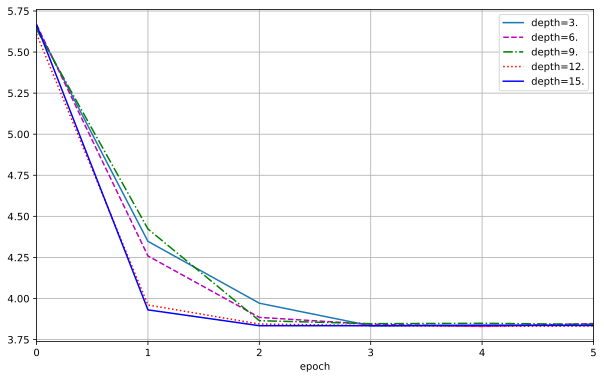

In [6]:
n_node, n_ants = 20, 20
k_sparse = 10
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP100: 

total training duration: 7316.2050495147705
epoch -1: (18.885487785339354, 18.833783950805664, 18.848322143554686, 18.837510585784912, 18.79073295593262)
epoch 0: (13.05448462486267, 12.151499328613282, 11.941965045928955, 10.340089817047119, 11.160923099517822)
epoch 1: (9.441569967269897, 9.060677366256714, 9.005743255615235, 8.857507963180542, 9.005911321640015)
epoch 2: (8.729478454589843, 8.66949239730835, 8.639853324890137, 8.685943975448609, 8.749258651733399)
epoch 3: (8.678040056228637, 8.651023335456848, 8.596454019546508, 8.602650117874145, 8.69906322479248)
epoch 4: (8.59030297756195, 8.613924984931947, 8.567655730247498, 8.579713101387023, 8.549263563156128)


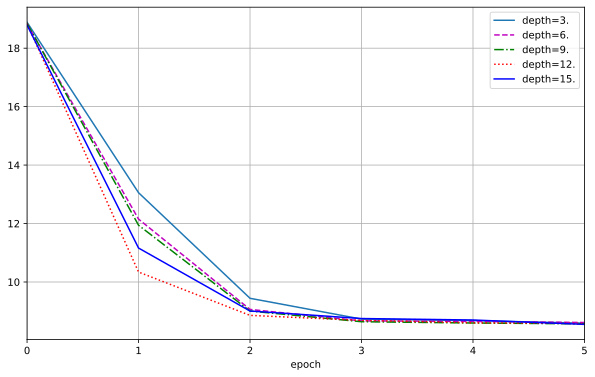

In [7]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)

Learn heuristic for TSP500: 

KeyboardInterrupt: 

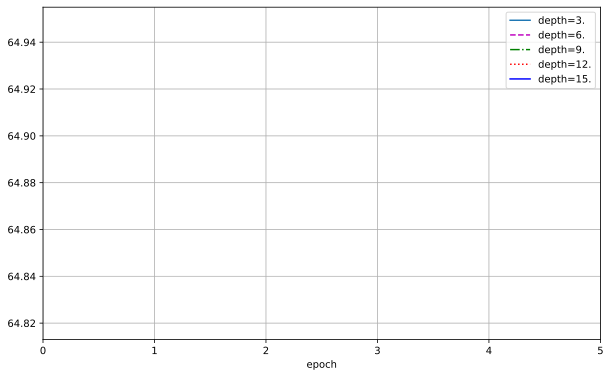

In [8]:
n_node = 500
n_ants = 50
k_sparse = 50
steps_per_epoch = 128
epochs = 5
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs)